In [2]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

In [3]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

In [7]:
snd = parselmouth.Sound("../AudioProcessing/audios/record-667269360.9571331.wav")

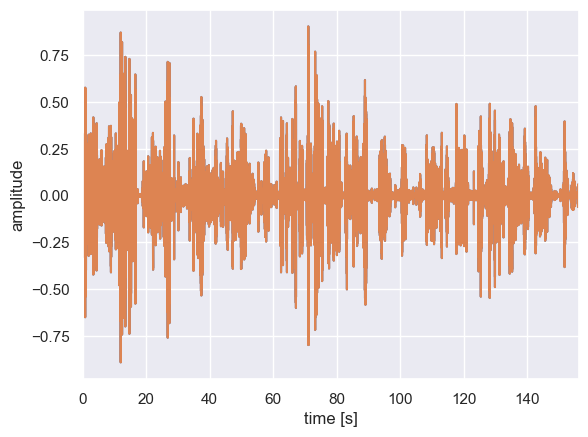

In [8]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

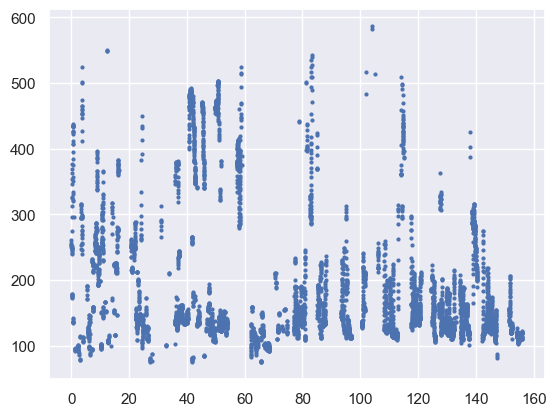

In [14]:
#Extracting frequency from the audio files
snd = parselmouth.Sound('../AudioProcessing/audios/record-667269360.9571331.wav')
pitch = snd.to_pitch()
pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values==0] = np.nan
plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
plt.show()

In [27]:
#Filter children's pitch (range between 250-400 Hz)
#The average man’s speaking voice, for example, typically has a fundamental frequency between 85 Hz and 155 Hz. A woman’s speech range is about 165 Hz to 255 Hz, and a child’s voice typically ranges from 250 Hz to 300 Hz and higher.
#https://www.axiomaudio.com/blog/audio-oddities-frequency-ranges-of-male-female-and-childrens-voices#:~:text=A%20woman's%20speech%20range%20is,to%20300%20Hz%20and%20higher.

#Declaring thresholds
threshold_high_pitch = 250
threshold_super_high_pitch = 400

secs_audio = pitch.xs()
secs_high_pitch = []
high_pitch_values = []
for i in range(0,len(pitch_values)):
    freq = pitch_values[i]
    if math.isnan(freq)!=True and (freq>=threshold_high_pitch and freq<=threshold_super_high_pitch):
        secs_high_pitch.append(secs_audio[i])
        high_pitch_values.append(pitch_values[i])

In [34]:
#Generation of the time intervals where there is a significant participation of the child (>= 1 second)
threshold_time_interval = 1.0
tuples_high_pitch_times = []
prev_sec = secs_high_pitch[0]
curr_time_tuple = (secs_high_pitch[0],)
for i in range(1,len(secs_high_pitch)):
    next_sec = secs_high_pitch[i]
    time_diff = next_sec - prev_sec
    if(time_diff>threshold_time_interval):
        curr_time_tuple+=(prev_sec,)
        tuples_high_pitch_times.append(curr_time_tuple)
        curr_time_tuple = (next_sec,)
    prev_sec = next_sec
tuples_high_pitch_times

[(0.04216553287982947, 0.7821655328798295),
 (3.2421655328798296, 3.7521655328798293),
 (8.142165532879831, 11.072165532879831),
 (14.17216553287983, 14.28216553287983),
 (15.92216553287983, 16.35216553287983),
 (20.702165532879828, 20.80216553287983),
 (21.832165532879827, 22.242165532879827),
 (24.202165532879828, 24.312165532879828),
 (30.93216553287983, 31.00216553287983),
 (36.02216553287983, 36.932165532879836),
 (40.682165532879836, 40.682165532879836),
 (41.73216553287983, 43.502165532879836),
 (45.692165532879834, 46.002165532879836),
 (51.322165532879836, 51.74216553287983),
 (57.262165532879834, 58.942165532879834),
 (81.39216553287983, 81.45216553287983),
 (82.64216553287983, 83.05216553287983),
 (84.98216553287983, 85.02216553287982),
 (95.14216553287983, 95.20216553287983),
 (105.99216553287982, 105.99216553287982),
 (108.38216553287982, 108.41216553287983),
 (113.01216553287983, 113.07216553287982),
 (114.12216553287983, 114.98216553287983),
 (117.66216553287983, 117.732

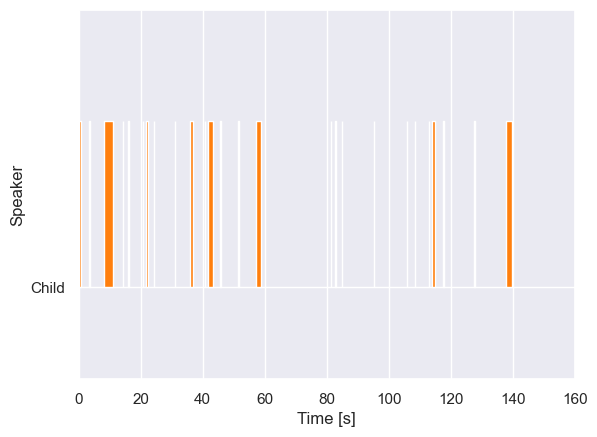

In [47]:
#https://www.geeksforgeeks.org/python-basic-gantt-chart-using-matplotlib/
# Declaring a figure "gnt"
fig, gnt = plt.subplots()

# Setting Y-axis limits
gnt.set_ylim(0, 20)

# Setting X-axis limits
gnt.set_xlim(0, 160)

# Setting labels for x-axis and y-axis
gnt.set_xlabel('Time [s]')
gnt.set_ylabel('Speaker')

# Setting ticks on y-axis
gnt.set_yticks([5])
# Labelling tickes of y-axis
gnt.set_yticklabels(['Child'])

# Setting graph attribute
gnt.grid(True)

#get data in the format that the plotter requires (second_start, duration_span)
timespan_data = []
for i in range(0,len(tuples_high_pitch_times)):
    time_tuple = tuples_high_pitch_times[i]
    plot_format_tuple = (time_tuple[0],time_tuple[1]-time_tuple[0])
    timespan_data.append(plot_format_tuple)

# Declaring multiple bars in at same level and same width
gnt.broken_barh(timespan_data, (5, 9),
                         facecolors ='tab:orange')